In [1]:
import keras
from keras.layers import Dense, Conv2D, BatchNormalization, Activation
from keras.layers import AveragePooling2D, Input, Flatten
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2
from keras import backend as K
from keras.models import Model
from keras.datasets import cifar10
from keras.utils import to_categorical
import numpy as np
import os

Using TensorFlow backend.


In [2]:
# Training parameters
batch_size = 32
epochs = 20
num_classes = 10

In [3]:
# Load the CIFAR10 data.
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [4]:
# Input image dimensions.
input_shape = x_train.shape[1:]
input_shape

(32, 32, 3)

In [5]:
# Normalize data.
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

In [6]:
# Subtracting pixel mean improves accuracy
x_train_mean = np.mean(x_train, axis=0)
x_train -= x_train_mean
x_test -= x_train_mean

In [7]:
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
print('y_train shape:', y_train.shape)

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples
y_train shape: (50000, 1)


In [8]:
# Convert class vectors to binary class matrices.
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

In [9]:
def lr_schedule(epoch):
    lr = 1e-3
    return lr

In [10]:
def resnet_layer(inputs,
                 num_filters=16,
                 kernel_size=3,
                 strides=1,
                 activation='relu',
                 batch_normalization=True,
                 conv_first=True):
    
    conv = Conv2D(num_filters,
                  kernel_size=kernel_size,
                  strides=strides,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))

    x = inputs
    if conv_first:
        x = conv(x)
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
    else:
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
        x = conv(x)
    return x

In [11]:
n = 3
depth = n * 6 + 2

In [12]:
def resnet(input_shape, depth, num_classes=10):
    # Start model definition.
    num_filters = 16
    num_res_blocks = int((depth - 2) / 6)

    inputs = Input(shape=input_shape)
    x = resnet_layer(inputs=inputs)
    # Instantiate the stack of residual units
    for stack in range(3):
        for res_block in range(num_res_blocks):
            strides = 1
            if stack > 0 and res_block == 0:  # first layer but not first stack
                strides = 2  # downsample
            y = resnet_layer(inputs=x,
                             num_filters=num_filters,
                             strides=strides)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters,
                             activation=None)
            if stack > 0 and res_block == 0:  # first layer but not first stack
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = keras.layers.add([x, y])
            x = Activation('relu')(x)
        num_filters *= 2

    # Add classifier on top.
    # v1 does not use BN after last shortcut connection-ReLU
    x = AveragePooling2D(pool_size=8)(x)
    y = Flatten()(x)
    outputs = Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(y)

    # Instantiate model.
    model = Model(inputs=inputs, outputs=outputs)
    return model

# Data Augmentation

In [13]:
datagen = ImageDataGenerator(
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    zca_epsilon=1e-06,
    rotation_range=0,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.,
    zoom_range=0.,
    channel_shift_range=0.,
    fill_mode='nearest',
    cval=0.,
    horizontal_flip=True,
    vertical_flip=False,
    rescale=None,
    preprocessing_function=None,
    data_format=None,
    validation_split=0.0)
    
datagen.fit(x_train)

# Compile the Model

In [14]:
model = resnet(input_shape=input_shape, depth=depth)
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(learning_rate=lr_schedule(0)),
              metrics=['accuracy'])

In [15]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 16)   448         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 32, 32, 16)   64          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 32, 32, 16)   0           batch_normalization_1[0][0]      
____________________________________________________________________________________________

In [17]:
# Prepare model model saving directory.
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'ResNet'
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)

In [18]:
# Prepare callbacks for model saving and for learning rate adjustment.
checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_acc',
                             verbose=1,
                             save_best_only=True)

lr_scheduler = LearningRateScheduler(lr_schedule)

lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6)

callbacks = [checkpoint, lr_reducer, lr_scheduler]

# Train the Model

In [20]:
model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
                    validation_data=(x_test, y_test),
                    epochs=epochs, verbose=1, workers=4,
                    callbacks=callbacks)

Epoch 1/20
1563/1563 [==============================] - 689s 441ms/step - loss: 1.5577 - accuracy: 0.4957 - val_loss: 1.3175 - val_accuracy: 0.5885
Epoch 2/20


C:\Users\raiya\Anaconda3\lib\site-packages\keras\callbacks\callbacks.py:707: RuntimeWarning: Can save best model only with val_acc available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


1563/1563 [==============================] - 663s 424ms/step - loss: 1.1732 - accuracy: 0.6413 - val_loss: 1.2601 - val_accuracy: 0.6216
Epoch 3/20
1563/1563 [==============================] - 671s 429ms/step - loss: 1.0148 - accuracy: 0.7013 - val_loss: 1.0874 - val_accuracy: 0.6923
Epoch 4/20
1563/1563 [==============================] - 664s 425ms/step - loss: 0.9275 - accuracy: 0.7355 - val_loss: 1.1463 - val_accuracy: 0.6708
Epoch 5/20
1563/1563 [==============================] - 659s 421ms/step - loss: 0.8659 - accuracy: 0.7572 - val_loss: 0.9603 - val_accuracy: 0.7298
Epoch 6/20
1563/1563 [==============================] - 660s 422ms/step - loss: 0.8216 - accuracy: 0.7751 - val_loss: 1.0897 - val_accuracy: 0.7083
Epoch 7/20
1563/1563 [==============================] - 665s 425ms/step - loss: 0.7919 - accuracy: 0.7874 - val_loss: 1.1992 - val_accuracy: 0.6876
Epoch 8/20
1563/1563 [==============================] - 761s 487ms/step - loss: 0.7577 - accuracy: 0.8002 - val_loss: 0.824

# Save the Model

In [38]:
fname = "weights-ResNetImageClassificationAug.hdf5"
model.save_weights(fname,overwrite=True)

In [39]:
from keras.models import load_model 
model.save('project_model.h5')

# Load Model

In [19]:
fname = "weights-ResNetImageClassificationAug.hdf5"
model.load_weights(fname)

In [40]:
from keras.models import load_model 
model = load_model('project_model.h5')

# Score trained Model

In [20]:
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

10000/10000 [==============================] - 51s 5ms/step
Test loss: 0.7889395555496216
Test accuracy: 0.801800012588501


# Test the Model

[[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]
Automobile


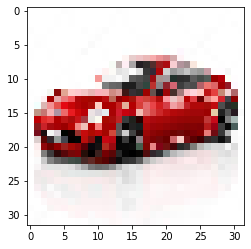

In [30]:
from keras.preprocessing import image
import matplotlib.pyplot as plt

test_image1 =image.load_img('Image/automobile1.jpg',target_size =(32,32,3))
test_image =image.img_to_array(test_image1) 
test_image =np.expand_dims(test_image, axis =0) 
result = model.predict(test_image)
plt.imshow(test_image1)

print(result) 
if result[0][0]==1: 
    print("Aeroplane") 
elif result[0][1]==1: 
    print('Automobile') 
elif result[0][2]==1: 
    print('Bird') 
elif result[0][3]==1: 
    print('Cat') 
elif result[0][4]==1: 
    print('Deer') 
elif result[0][5]==1: 
    print('Dog') 
elif result[0][6]==1: 
    print('Frog') 
elif result[0][7]==1: 
    print('Horse') 
elif result[0][8]==1: 
    print('Ship') 
elif result[0][9]==1: 
    print('Truck') 
else:
    print('Error')

In [24]:
class_name =['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']

index = np.argsort(result[0,:])
print('Most likely class :', class_name[index[9]] , ', Probability : ', result[0 , index[9]])
print('Most second  likely class :', class_name[index[8]] , ', Probability : ', result[0 , index[8]])
print('Most third  likely class :', class_name[index[7]] , ', Probability : ', result[0 , index[7]])

Most likely class : automobile , Probability :  1.0
Most second  likely class : truck , Probability :  0.0
Most third  likely class : ship , Probability :  0.0
